
## Steps involved in the detection and segmentation of tumors in MR Brain images (The Project).

**Steps**:
+ **Data Preparation**

+ **Data Visualization**

+ **Train and evaluate Ensemble Model**

+ **Train and evaluate UNet for segmentation**

+ **Prediction on test data**

+ **Visualization of the prediction on test data**

+ **Building the app**

+ **NB:** 
This notebook contains the pre-processing and visualization aspect of the project(steps 1 and 2). TheEnsembleModel notebook contains the training and evalution of four models and the ensemble (step 3). TheSegmentationModel notebook contains the training and evaluation of the UNET segmentation model (step 4). And the TestingTheModel notebook does justice to the fifth and sixth step.

*Below, we import the neccessary modules and packages(mostly third party)* 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from mpl_toolkits.axes_grid import ImageGrid
plt.style.use("dark_background")
from skimage import io

<ipython-input-1-6ee4f095a3c9>:8: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import ImageGrid


### LGG Segmentation Dataset
Dataset used in here:

Mateusz Buda, AshirbaniSaha, Maciej A. Mazurowski "Association of genomic subtypes of lower-grade gliomas with shape features automatically extracted by a deep learning algorithm." Computers in Biology and Medicine, 2019.

and

Maciej A. Mazurowski, Kal Clark, Nicholas M. Czarnek, Parisa Shamsesfandabadi, Katherine B. Peters, Ashirbani Saha "Radiogenomics of lower-grade glioma: algorithmically-assessed tumor shape is associated with tumor genomic subtypes and patient outcomes in a multi-institutional study with The Cancer Genome Atlas data." Journal of Neuro-Oncology, 2017.

This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.
Tumor genomic clusters and patient data is provided in data.csv file.

To read more on this [Dataset](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation)

## Data Preparation

In [2]:
#Changed to working directory to the location of the dataset and loaded the dataset description.
os.chdir("..\kaggle_3m")
brain_df = pd.read_csv('data_frame.csv')

In [3]:
# Here we decided to drop unncessary coloums from the dataset
brain_df.drop(['Unnamed: 0', 'patient'], axis=1)

image_path  \
0     ../kaggle_3m\TCGA_CS_4941_19960909/TCGA_CS_494...   
1     ../kaggle_3m\TCGA_CS_4942_19970222/TCGA_CS_494...   
2     ../kaggle_3m\TCGA_CS_4943_20000902/TCGA_CS_494...   
3     ../kaggle_3m\TCGA_CS_4944_20010208/TCGA_CS_494...   
4     ../kaggle_3m\TCGA_CS_5393_19990606/TCGA_CS_539...   
...                                                 ...   
3924  ../kaggle_3m\TCGA_HT_A61B_19991127/TCGA_HT_A61...   
3925  ../kaggle_3m\TCGA_HT_A61A_20000127/TCGA_HT_A61...   
3926  ../kaggle_3m\TCGA_HT_A61B_19991127/TCGA_HT_A61...   
3927  ../kaggle_3m\TCGA_HT_A61A_20000127/TCGA_HT_A61...   
3928  ../kaggle_3m\TCGA_HT_A61B_19991127/TCGA_HT_A61...   

                                              mask_path  diagnosis  
0     ../kaggle_3m\TCGA_CS_4941_19960909/TCGA_CS_494...          0  
1     ../kaggle_3m\TCGA_CS_4942_19970222/TCGA_CS_494...          0  
2     ../kaggle_3m\TCGA_CS_4943_20000902/TCGA_CS_494...          0  
3     ../kaggle_3m\TCGA_CS_4944_20010208/TCGA_CS_494...          0  
4     ../kaggle_3m\TCGA_CS_5393_19990606/TCGA_CS_539...          0  
...                                                 ...        ...  
3924  ../kaggle_3m\TCGA_HT_A61B_19991127/TCGA_HT_A61...          0  
3925  ../kaggle_3m\TCGA_HT_A61A_20000127/TCGA_HT_A61...          0  
3926  ../kaggle_3m\TCGA_HT_A61B_19991127/TCGA_HT_A61...          0  
3927  ../kaggle_3m\TCGA_HT_A61A_20000127/TCGA_HT_A61...          0  
3928  ../kaggle_3m\TCGA_HT_A61B_19991127/TCGA_HT_A61...          0  

[3929 rows x 3 columns]

## Data Visualization

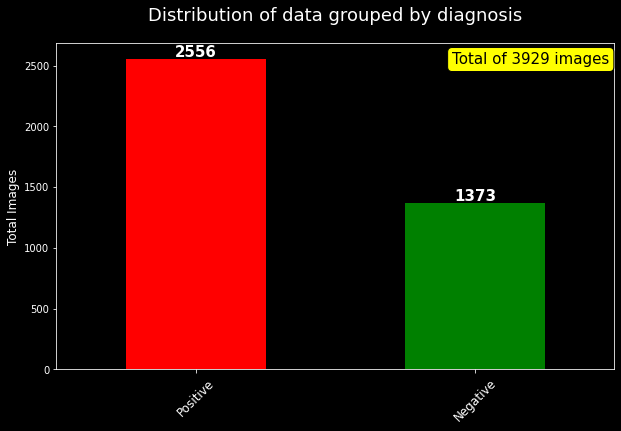

In [4]:
# Plots a bar chart of the dataset showing the number of data per class 
ax = brain_df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["red", "green"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(brain_df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total of {len(brain_df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("yellow"),
                   ec=("black"),
                   )
         );

## Data Distribution

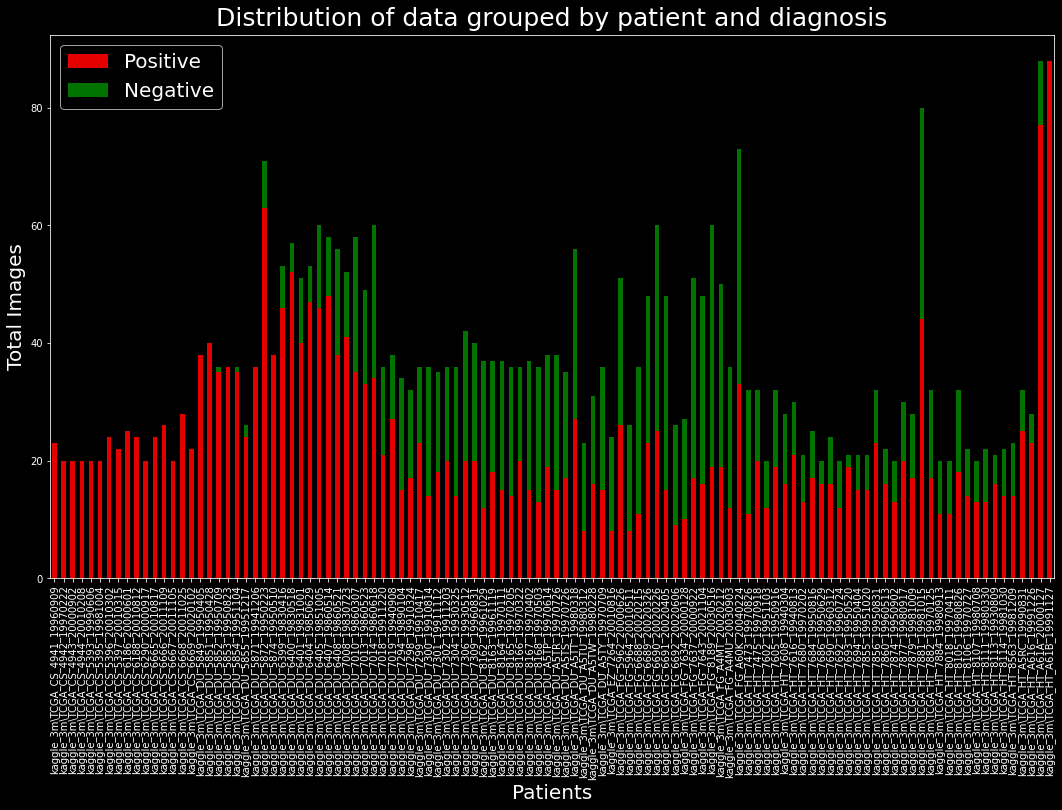

In [5]:
# Data
patients_by_diagnosis = brain_df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["red", "green"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)

# Annotations
"""for i, rows in enumerate(patients_by_diagnosis.values):
    plt.annotate(int(rows[0]), xy=(i, rows[0]+1), rotation=90, color="white")
    plt.annotate(int(rows[1]), xy=(i, rows[1]+1), rotation=90, color="aqua")""";

## Futher Data Visualization

### Samples of images with a positive and negative diagnosis

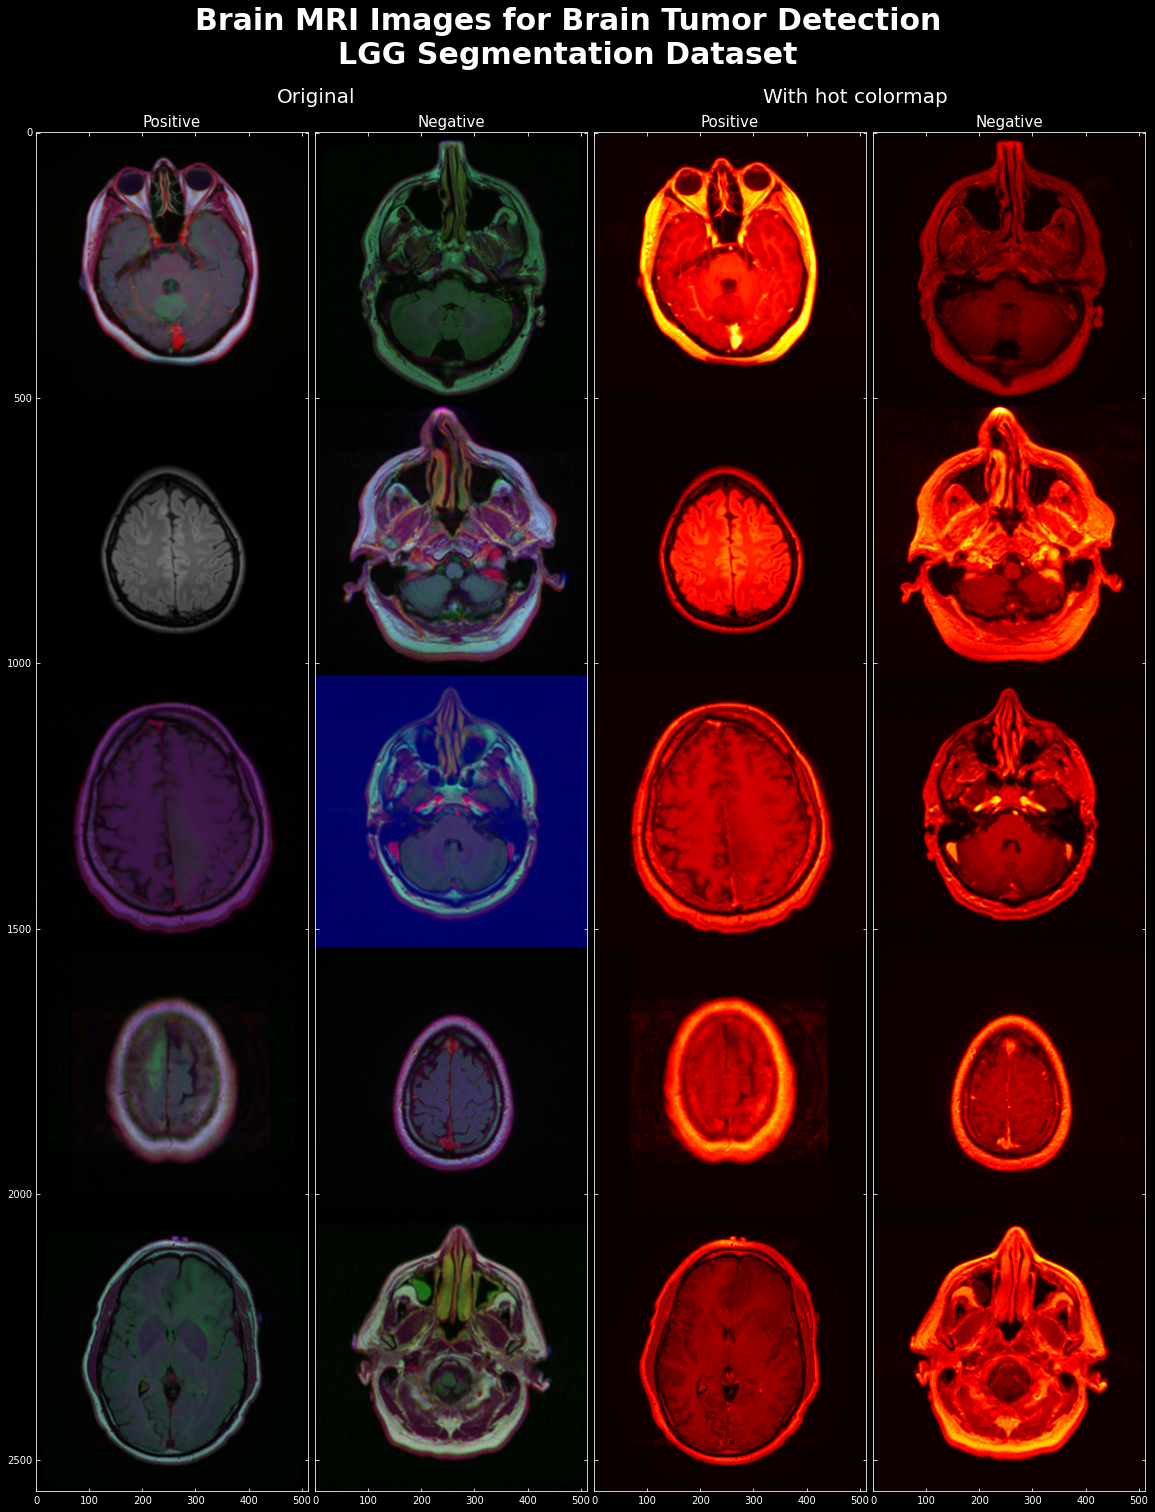

In [6]:
# plots samples of the data (both positive and negative) and then with hot color map. This was
# done in order to gain insights through visualisation
sample_yes_df = brain_df[brain_df["diagnosis"] == 1].sample(5).image_path.values
sample_no_df = brain_df[brain_df["diagnosis"] == 0].sample(5).image_path.values
IMG_SIZE = 512
sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])


sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")#set_title("No", fontsize=15)

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

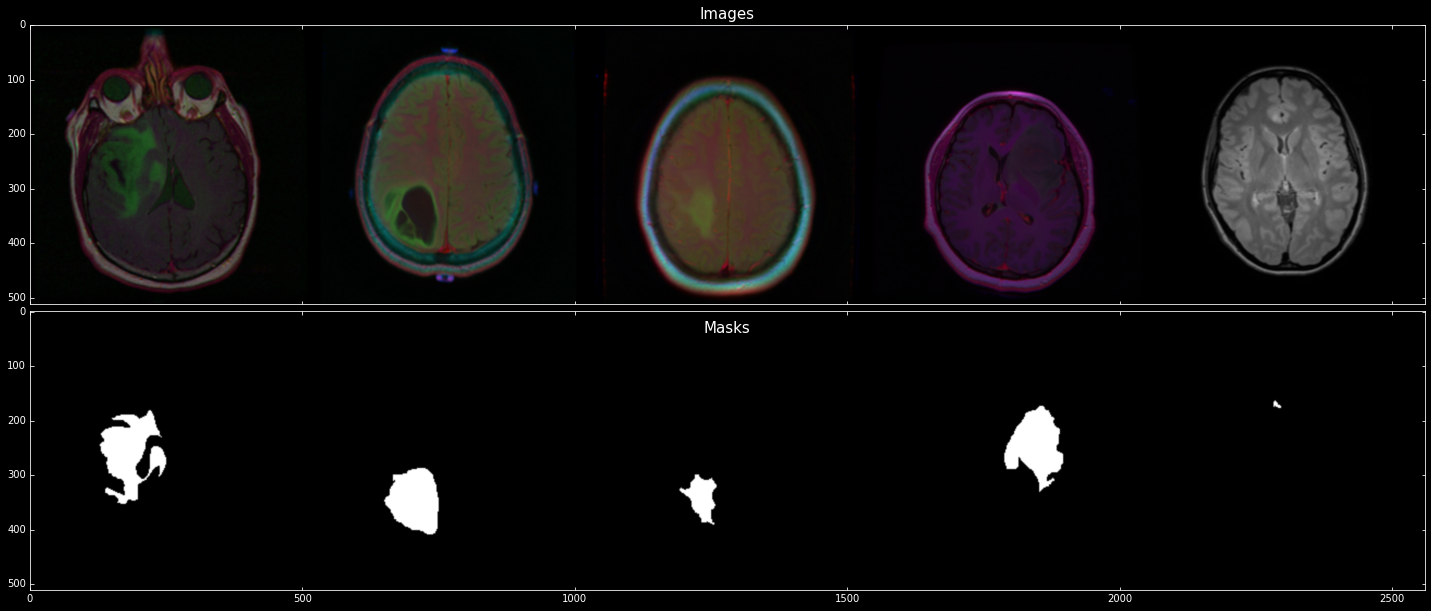

In [7]:
# Here we plot images with tumors along with thier corresponding masks showing the exact tumor location.
sample_df = brain_df[brain_df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    #print(data)
    img = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[3]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])1
    


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()

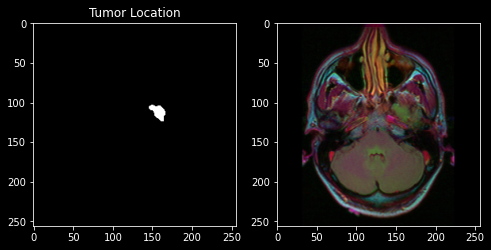

In [8]:
# A single image plotted with it's tumor location
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));

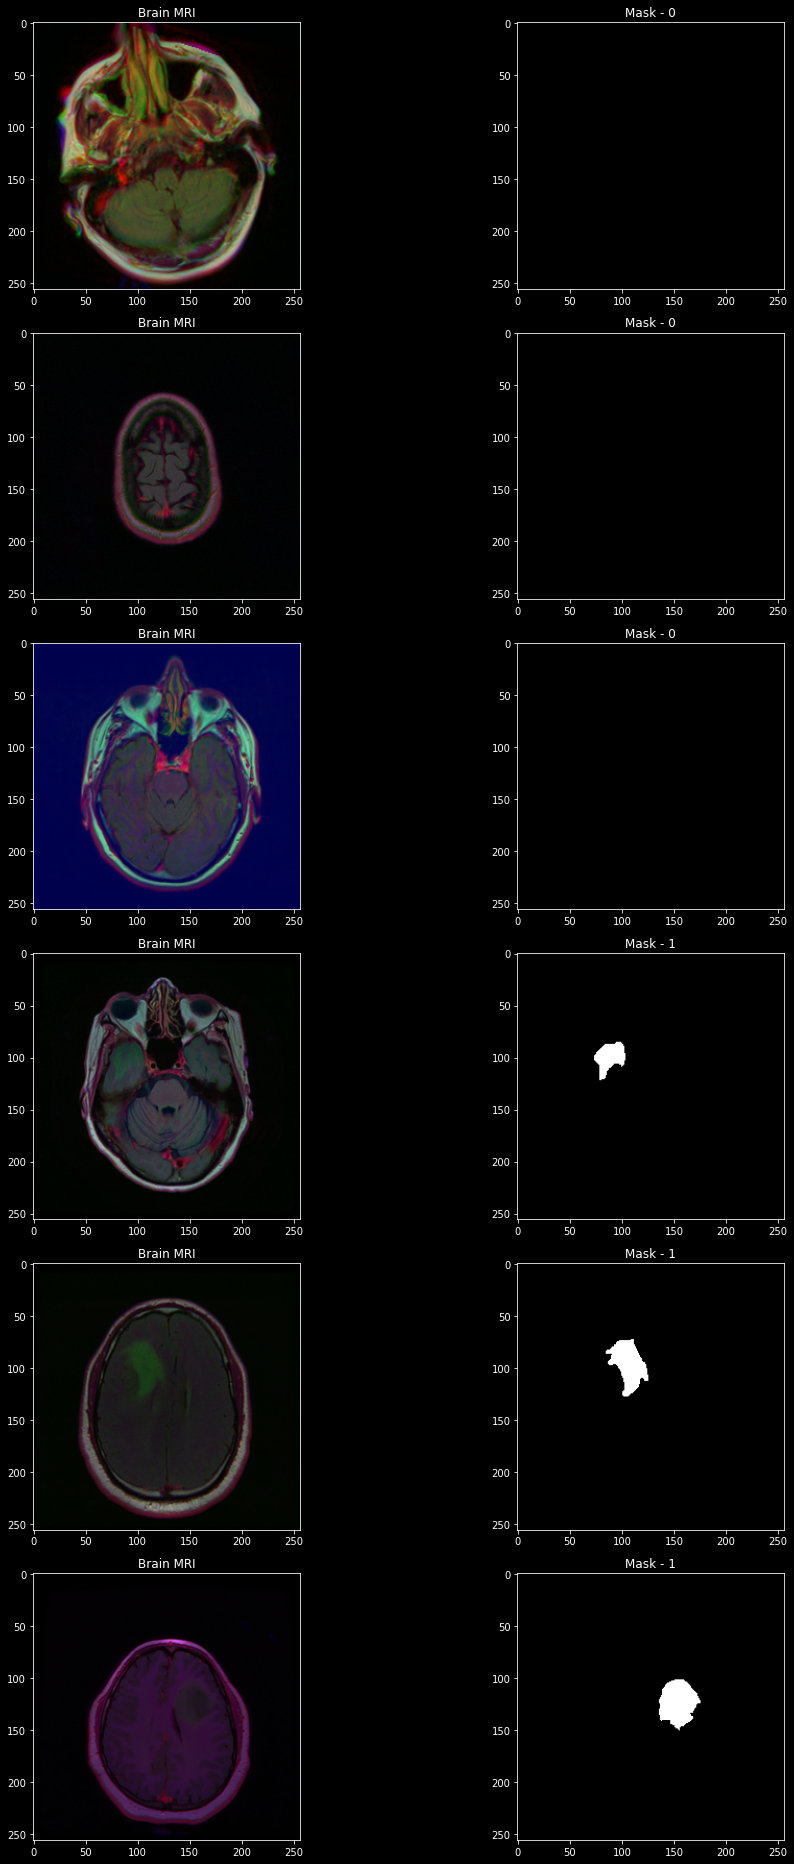

In [9]:
#here we decided to plot random data and with their corresponding masks. 1 represents tumor present and 0 otherwise.
fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['diagnosis'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

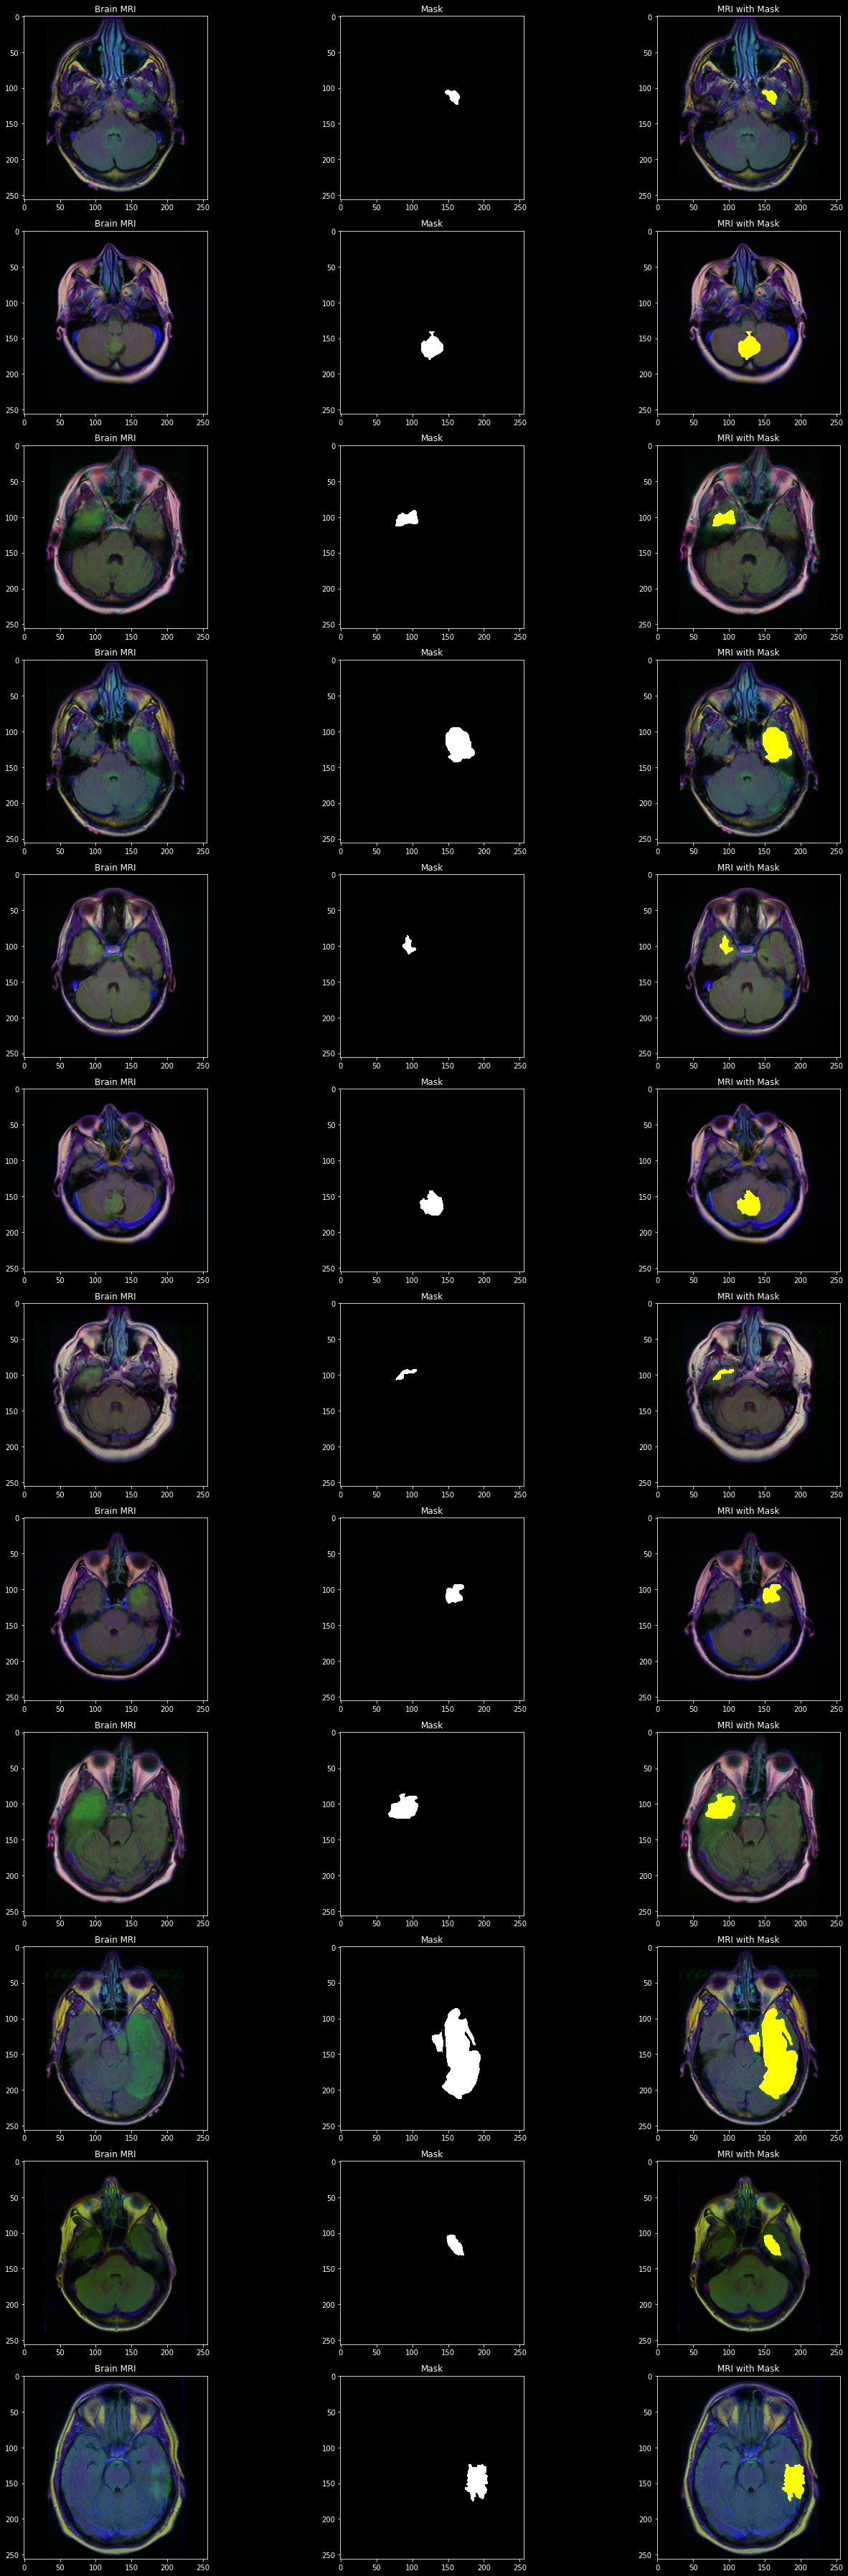

In [10]:
#And here we plotted images with tumor present and there respective masks, then highlighted the tumor location on the images.
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brain_df['diagnosis']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (255,255,0)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break
        
fig.tight_layout()

# THE MODELS 

**The models needed for the ensemble**:

+ **EfficientNetV2**

+ **MobileNet**

+ **MobileNetv2**

+ **NasNet**

*It is worth noting that these models were carefully researched and selected to perfectly match/fit our target. Remember them?*
*Each of these transfer learning models have been re-trained on the same dataset in the **TheEnsembleModel** notebook which is then ensembled to have a voting classifier.*

###### 